# Modelling 'Junkie' Drugs

In [40]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_columns", None)

In [27]:
data = pd.read_excel("../../data/raw/drug_consumption.xls")

## Process Data
* Change the prefix in the values of the Drug columns and convert them into interger
* Drop the rows that contain the fictiuos drug (Semer)
* Drop unnecessary columns (ID and Semer)

In [28]:
drugs = data.columns[13:]
for drug in drugs: 
    data[drug] = data[drug].str.replace('CL', '').astype('int')
    
data.query('Semer == 0', inplace = True)

data.drop('ID', axis=1, inplace=True)
data.drop('Semer', axis=1, inplace=True)

## Categorize 'Junkie' Drugs
* Categorization is based on the corretaion between the drugs as well as in compliance with information relevant to the business case 
* In this case the threshold, as of when somebody is classified as a 'user' is if the individual used this drug more recently than in the last decade
* A new colums is created which contains the combination of the categorized drugs

In [29]:
illegal_drugs2 = ['Meth', 'Benzos', 'Heroin', 'Crack']

for drug in illegal_drugs2:
    data[drug+'_bin'] = [1 if d > 1 else 0 for d in data[drug].values]

data['illegal_drugs_2'] = data['Meth_bin'] + data['Benzos_bin'] + data['Heroin_bin'] + data['Crack_bin']

data['illegal_drugs_2'] = [1 if ill > 0 else 0 for ill in data.illegal_drugs_2.values]

data.illegal_drugs_2.value_counts()

0    1025
1     852
Name: illegal_drugs_2, dtype: int64

## Train Test Split

In [30]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(data, test_size=0.33, random_state=1, stratify=data['illegal_drugs_2'])

## Define X and Y

In [31]:
X = df.iloc[:,:12]
y = df['illegal_drugs_2']
features = list(X.columns)

Ratio of user and non-user:

In [32]:
df.illegal_drugs_2.value_counts()/df.shape[0]

0    0.545744
1    0.454256
Name: illegal_drugs_2, dtype: float64

## Create Baseline Model - Bayes
To be able to compare the progress of other models. <br>
Here a simple Naive Bayes Model was choosen as the baseline model


              precision    recall  f1-score   support

           0       0.73      0.74      0.73       686
           1       0.68      0.67      0.68       571

    accuracy                           0.71      1257
   macro avg       0.71      0.71      0.71      1257
weighted avg       0.71      0.71      0.71      1257



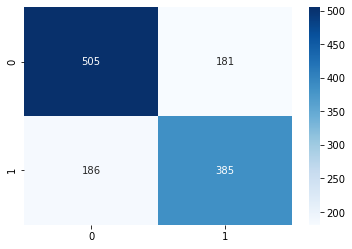

In [33]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = cross_val_predict(gnb, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
print(classification_report(y, y_pred))
sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');

## SMOTE
To be able to handel imbalanced data the data was oversampled with SMOTE.

In [53]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

# Models
First some 'simpler' models were trained. 
* Decision Tree
* Random Forest
* SVM

### Decision Tree

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       686
           1       0.69      0.71      0.70       686

    accuracy                           0.70      1372
   macro avg       0.70      0.70      0.70      1372
weighted avg       0.70      0.70      0.70      1372



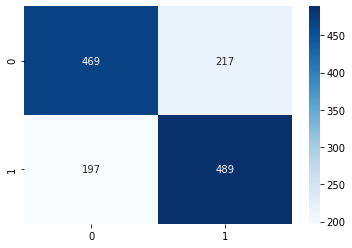

In [35]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=5)

y_pred = cross_val_predict(dtree, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred)
print(classification_report(y_smote, y_pred))
sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

rnc = RandomForestClassifier(random_state=10)

y_pred = cross_val_predict(rnc, X_smote, y_smote, cv=5)
rnc.fit(X_smote,y_smote) 
cm = confusion_matrix(y_smote, y_pred)
print(classification_report(y_smote, y_pred))
sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       686
           1       0.73      0.74      0.73       686

    accuracy                           0.73      1372
   macro avg       0.73      0.73      0.73      1372
weighted avg       0.73      0.73      0.73      1372

[[501 185]
 [181 505]]


### SVM

In [37]:
from sklearn import svm

svm = svm.SVC(kernel='rbf')

y_pred = cross_val_predict(svm, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred)
print(classification_report(y_smote, y_pred))
sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       686
           1       0.71      0.74      0.73       686

    accuracy                           0.72      1372
   macro avg       0.72      0.72      0.72      1372
weighted avg       0.72      0.72      0.72      1372

[[480 206]
 [177 509]]


# Ensemble Methods
* Adaboost
* XGboost

### Adaboost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state = 101)

y_pred = cross_val_predict(ada, X_smote, y_smote, cv=5)
ada.fit(X_smote,y_smote) 
cm = confusion_matrix(y_smote, y_pred)
print(classification_report(y_smote, y_pred))
sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       686
           1       0.71      0.66      0.68       686

    accuracy                           0.69      1372
   macro avg       0.70      0.69      0.69      1372
weighted avg       0.70      0.69      0.69      1372

[[498 188]
 [231 455]]


### XGboost

In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

y_pred = cross_val_predict(xgb, X_smote, y_smote, cv=5)
xgb.fit(X_smote,y_smote) 
cm = confusion_matrix(y_smote, y_pred)
print(classification_report(y_smote, y_pred))
sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       686
           1       0.71      0.69      0.70       686

    accuracy                           0.71      1372
   macro avg       0.71      0.71      0.71      1372
weighted avg       0.71      0.71      0.71      1372

[[494 192]
 [212 474]]


# Hyperparemeter tuning
--> GridSearch 
* Random Forest
* ensemble Methods
* SVM

### GridSearch Adaboost

In [41]:
from sklearn.metrics import fbeta_score, make_scorer

ada = AdaBoostClassifier()

parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.]                            
             } 


scorer = {'ftwo_scorer':make_scorer(fbeta_score, beta=1000, average='weighted'), 'prec':'precision', 'rec':'recall', 'f1':'f1'}

grid_ada = GridSearchCV(ada, parameters, scoring =scorer, refit='f1') 

grid_ada.fit(X_smote,y_smote) 
best_ada = grid_ada.best_estimator_ 
y_pred = best_ada.predict(X_smote)


print('Best score:\n{:.2f}'.format(grid_ada.best_score_))
print("Best parameters:\n{}".format(grid_ada.best_params_))

df_ada = pd.DataFrame(grid_ada.cv_results_ )
print(classification_report(y_smote, y_pred))

Best score:
0.71
Best parameters:
{'learning_rate': 0.1, 'n_estimators': 120}
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       686
           1       0.74      0.72      0.73       686

    accuracy                           0.73      1372
   macro avg       0.74      0.73      0.73      1372
weighted avg       0.74      0.73      0.73      1372



### GridSearch XGboost

In [42]:
xgb = XGBClassifier()

parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

scorer = {'ftwo_scorer':make_scorer(fbeta_score, beta=1000, average='weighted'), 'prec':'precision', 'rec':'recall', 'f1':'f1'}

grid_xgb = GridSearchCV(xgb, parameters, scorer, refit='f1')

grid_xgb.fit(X_smote,y_smote) 
best_xgb = grid_xgb.best_estimator_ 
y_pred = best_xgb.predict(X_smote)


print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))
df_xgb = pd.DataFrame(grid_xgb.cv_results_ )
print(classification_report(y_smote, y_pred))

/Users/carlottaulm/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring={'ftwo_scorer': make_scorer(fbeta_score, beta=1000, average=weighted), 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'} as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Best score:
0.72
Best parameters:
{'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       686
           1       0.81      0.83      0.82       686

    accuracy                           0.82      1372
   macro avg       0.82      0.82      0.82      1372
weighted avg       0.82      0.82      0.82      1372



### GridSearch RandomForest

In [43]:
from sklearn.model_selection import RandomizedSearchCV

rnc = RandomForestClassifier()

parameters = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5],
    'criterion' :['gini', 'entropy']
}


scorer = {'ftwo_scorer':make_scorer(fbeta_score, beta=1000, average='weighted'), 'prec':'precision', 'rec':'recall', 'f1':'f1'}

grid_rnc = GridSearchCV(rnc, parameters, scoring =scorer, refit='f1') 


grid_rnc.fit(X_smote,y_smote) 
best_rnc = grid_rnc.best_estimator_ 
y_pred = best_rnc.predict(X_smote)

print('Best score:\n{:.2f}'.format(grid_rnc.best_score_))
print("Best parameters:\n{}".format(grid_rnc.best_params_))
df_rnc = pd.DataFrame(grid_rnc.cv_results_ )


cm = confusion_matrix(y_smote, y_pred)
print(classification_report(y_smote, y_pred))
print(cm)

Best score:
0.73
Best parameters:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       686
           1       0.75      0.76      0.75       686

    accuracy                           0.75      1372
   macro avg       0.75      0.75      0.75      1372
weighted avg       0.75      0.75      0.75      1372

[[512 174]
 [167 519]]


### GridSearch SVM

In [50]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')

parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000],
                    }]

scorer = {'ftwo_scorer':make_scorer(fbeta_score, beta=1000, average='weighted'), 'prec':'precision', 'rec':'recall', 'f1':'f1'}

grid_svc = GridSearchCV(svc, parameters, scoring =scorer, refit='f1') 

grid_svc.fit(X_smote,y_smote) 
best_svc = grid_svc.best_estimator_ 
y_pred = best_svc.predict(X_smote)


print('Best score:\n{:.2f}'.format(grid_svc.best_score_))
print("Best parameters:\n{}".format(grid_svc.best_params_))
print
df_ada = pd.DataFrame(grid_svc.cv_results_ )
print(classification_report(y_smote, y_pred))

Best score:
0.71
Best parameters:
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       686
           1       0.73      0.70      0.71       686

    accuracy                           0.72      1372
   macro avg       0.72      0.72      0.72      1372
weighted avg       0.72      0.72      0.72      1372



# Model evaluation
* Evaluation of the best Models with the Test Data
* Evaluation of feature importance: <br>
    The features considers the most important <br>
    The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used. 

In [45]:
X_test = df_test.iloc[:,:12]
y_test = df_test['illegal_drugs_2']

### Evaluate Random Forest

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       339
           1       0.69      0.70      0.69       281

    accuracy                           0.72       620
   macro avg       0.72      0.72      0.72       620
weighted avg       0.72      0.72      0.72       620



Text(0.5, 1.0, 'Random Forest')

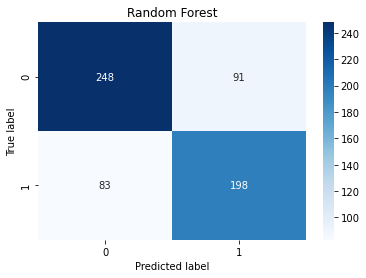

In [46]:
y_test_pred = best_rnc.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Random Forest')

### Evaluate XGboost

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       339
           1       0.68      0.68      0.68       281

    accuracy                           0.71       620
   macro avg       0.71      0.71      0.71       620
weighted avg       0.71      0.71      0.71       620



Text(0.5, 1.0, 'XGboost')

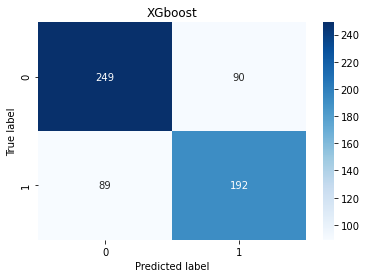

In [47]:
y_test_pred = best_xgb.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('XGboost')

### Evaluate Adaboost

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       339
           1       0.72      0.68      0.70       281

    accuracy                           0.74       620
   macro avg       0.73      0.73      0.73       620
weighted avg       0.73      0.74      0.73       620



,feature,importance
5,Nscore,0.191667
3,Country,0.150000
2,Education,0.116667
7,Oscore,0.108333
10,Impulsive,0.083333


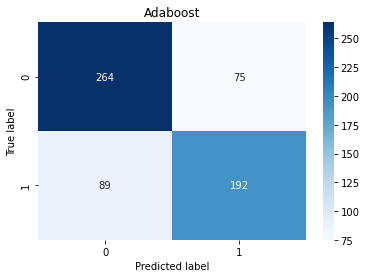

In [52]:
y_test_pred = best_ada.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Adaboost')

fi_ada_grid = pd.DataFrame({'feature': features,
                   'importance': best_ada.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_ada_grid.head(5)

### Evaluate SVM

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       339
           1       0.68      0.66      0.67       281

    accuracy                           0.70       620
   macro avg       0.70      0.70      0.70       620
weighted avg       0.70      0.70      0.70       620



Text(0.5, 1.0, 'SVC')

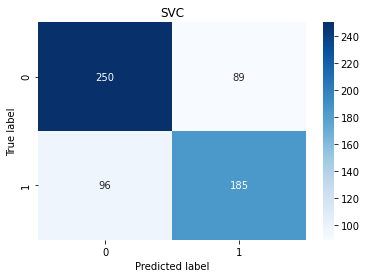

In [51]:
y_test_pred = best_svc.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

sns.heatmap(cm, annot=True, 
            cmap='Blues', fmt='.0f');
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('SVC')